In [1]:
import torch
import numpy as np
import pandas as pd
import os

os.chdir("../")

%load_ext autoreload
%autoreload 2

In [14]:
data = pd.read_csv("./notebooks/train_runs_2025-05-07_08-21-24_tensorboard_version_0.csv")
data["Step"] = data["Step"].div(data.iloc[0]["Step"]).astype(int)
data

,Wall time,Step,Value
0,1.746617e+09,1,0.817734
1,1.746617e+09,2,0.471153
2,1.746617e+09,3,0.347041
3,1.746617e+09,4,0.263684
4,1.746618e+09,5,0.232428
...,...,...,...
295,1.746653e+09,296,0.061789
296,1.746653e+09,297,0.062391
297,1.746653e+09,298,0.062047
298,1.746653e+09,299,0.062778


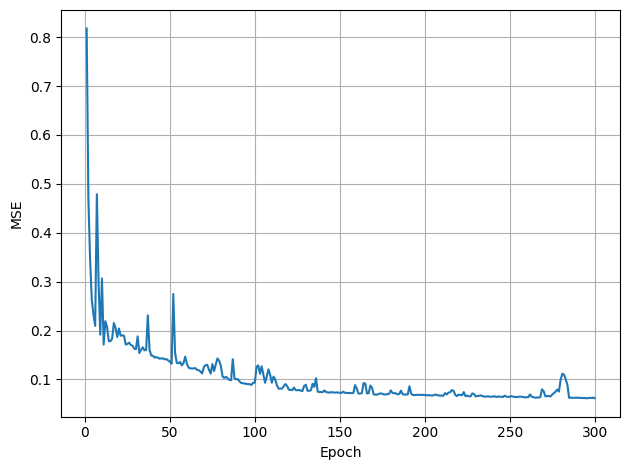

In [16]:
from matplotlib import pyplot as plt

plt.plot(data["Step"], data["Value"])
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.grid()
plt.tight_layout()
plt.show()

In [14]:
from src.data.components.pastis import PASTISSubpatchedDatasetS2

finetun_subset = PASTISSubpatchedDatasetS2(
    os.getenv("PASTIS_DATA_DIR", ""),
    4,
    [4]
)
len(finetun_subset)

INFO:src.data.components.pastis:[rank: 0] Loading PASTIS metadata from /home/jpulzdeoliveira/datasets/PASTIS/metadata.geojson, folds: [4]
INFO:src.data.components.pastis:[rank: 0] Loading PASTIS mean and std from /home/jpulzdeoliveira/datasets/PASTIS/NORM_S2_patch.json, folds: [4]
INFO:src.data.components.pastis:[rank: 0] Loaded PASTIS dataset with 482 samples


5419

In [3]:
from torch.utils.data import Subset, SubsetRandomSampler

seed = 42

torch.manual_seed(seed)

def get_dataset_indices(dataset, n_shot):
    dataset_len = len(dataset)
    return torch.randperm(dataset_len, generator=torch.Generator().manual_seed(n_shot))[:dataset_len * n_shot // 100]

def get_subset(dataset, indices):
    return Subset(dataset, indices)

def get_few_shot_dataset(dataset, n_shot):
    indices = get_dataset_indices(dataset, n_shot)
    return get_subset(dataset, indices)

In [4]:
len(get_few_shot_dataset(finetun_subset, 1))

54

In [5]:
from src.data.base_datamodule import BaseDataModule

datamodule = BaseDataModule(get_few_shot_dataset(finetun_subset, 1))

In [45]:
path = "/home/jpulzdeoliveira/github/sits-crop-recognition/logs/train/runs/2025-05-07_08-21-24/checkpoints/last.ckpt"
os.path.exists(path), os.path.isfile(path)

(True, True)

In [46]:
from src.models.mae_module import MAEModule
from src.models.modules.encoders import prithvi_mae

model = MAEModule.load_from_checkpoint(path, net=prithvi_mae.PrithviMAE(img_size=128, in_channels=10, num_frames=4))
model

MAEModule(
  (criterion): CrossEntropyLoss()
  (net): PrithviMAE(
    (encoder): PrithviViT(
      (patch_embed): PatchEmbed(
        (proj): Conv3d(10, 768, kernel_size=(1, 16, 16), stride=(1, 16, 16))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='no

In [47]:
x = finetun_subset[0]
x["data"].shape

(4, 10, 128, 128)

In [48]:
pred = model(torch.from_numpy(x["data"]).unsqueeze(0).permute(0, 2, 1, 3, 4))
pred

(tensor(0.1199, grad_fn=<DivBackward0>),
 tensor([[[ 0.3725,  0.4270,  0.4478,  ..., -0.2453, -0.3963, -0.3234],
          [-0.0159,  0.0658,  0.0186,  ...,  0.0259, -0.0860, -0.0838],
          [ 0.3505,  0.3638,  0.2971,  ...,  0.4372, -0.2165, -0.3779],
          ...,
          [-0.4701, -0.4721, -0.5505,  ..., -0.5026, -0.5647, -0.5383],
          [-0.4423, -0.4233, -0.5138,  ..., -0.5022, -0.0653,  0.0203],
          [-0.3164, -0.3012, -0.2686,  ..., -0.2482, -0.3267, -0.3592]]],
        grad_fn=<SliceBackward0>),
 tensor([[[ 0.4198,  0.5367,  0.5352,  ..., -0.2713, -0.6895, -0.5314],
          [-0.2321, -0.1712, -0.0637,  ...,  0.0805,  0.0220,  0.1505],
          [-0.0138,  0.0387,  0.1262,  ...,  0.4250, -0.0488, -0.3542],
          ...,
          [-0.4606, -0.4562, -0.5525,  ..., -0.4108, -0.6337, -0.6311],
          [-0.4131, -0.3773, -0.4798,  ..., -0.6299, -0.0148,  0.2333],
          [-0.3402, -0.3579, -0.4056,  ..., -0.0663, -0.2912, -0.4470]]]),
 None,
 tensor([[0., 1., 

In [49]:
y_hat = model.net.unpatchify(pred[1])
y_hat.shape

torch.Size([1, 10, 4, 128, 128])

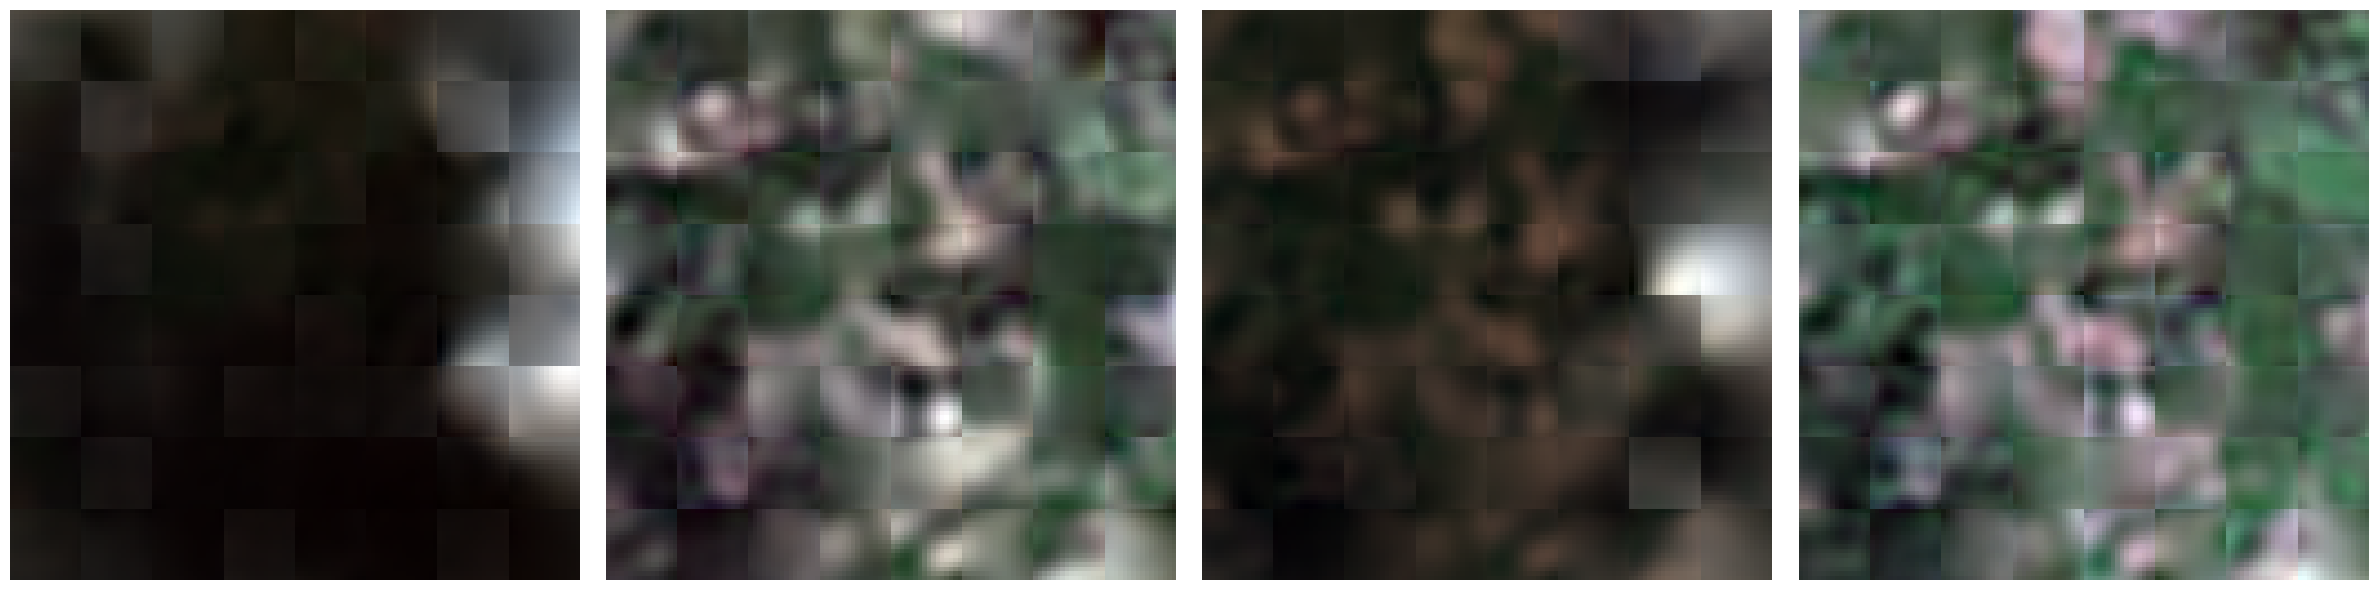

In [50]:
from src.utils.plotting import make_grid_tensor, normalize_img_tensor, plot_multi_img_tensor

fig, ax = plot_multi_img_tensor(normalize_img_tensor(y_hat[0, [2, 1, 0]]))
fig.show()

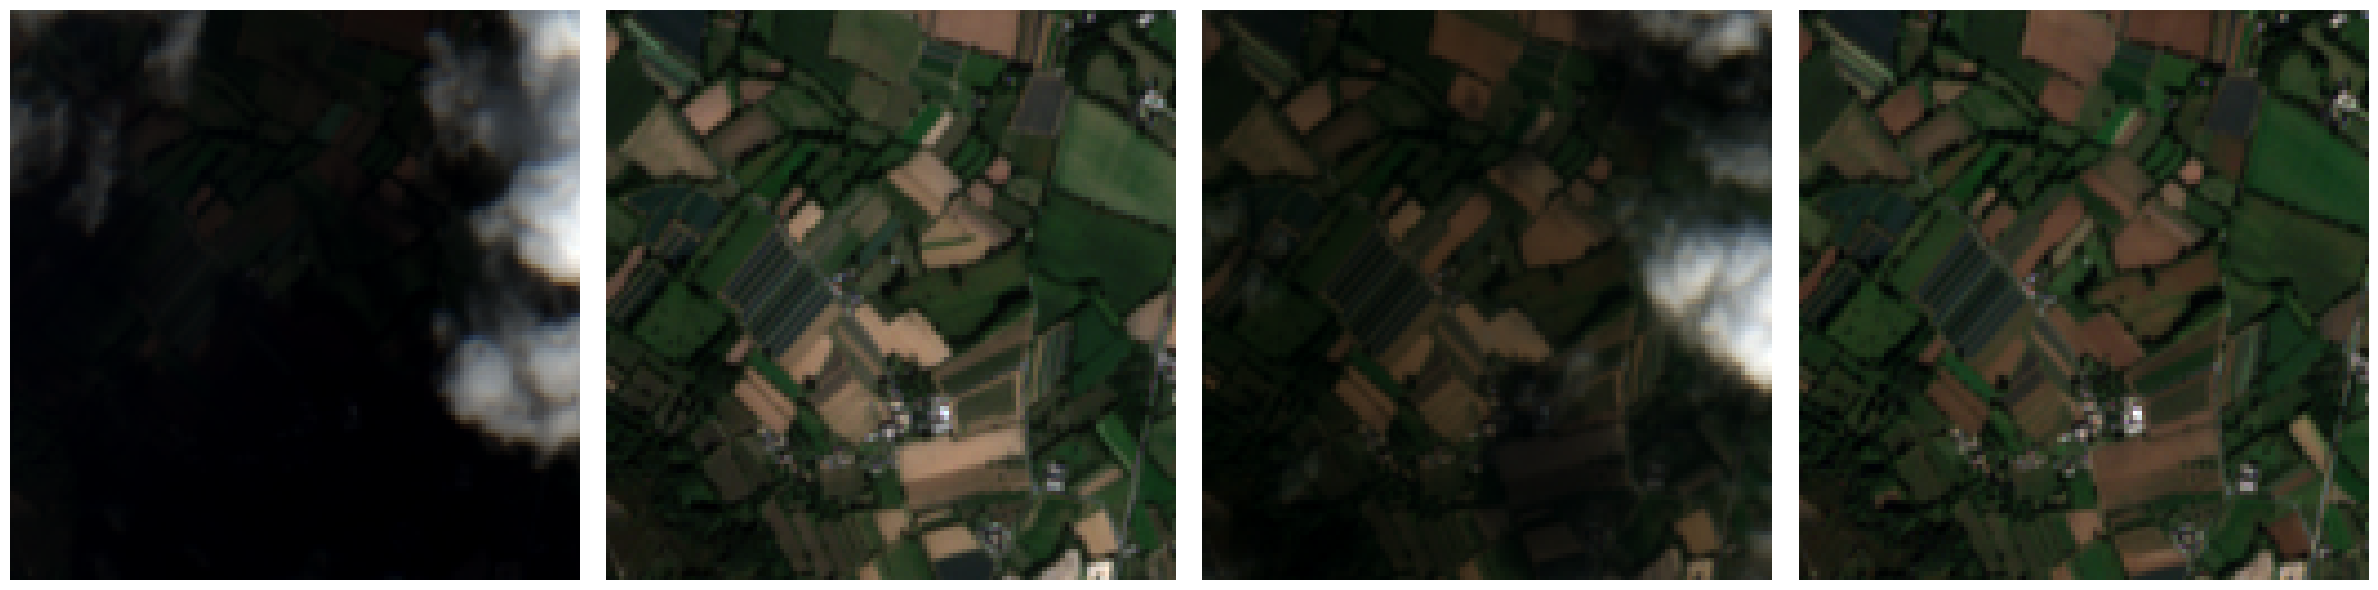

In [51]:
y_hat = model.net.unpatchify(pred[2])
fig, ax = plot_multi_img_tensor(normalize_img_tensor(y_hat[0, [2, 1, 0]]))
fig.show()